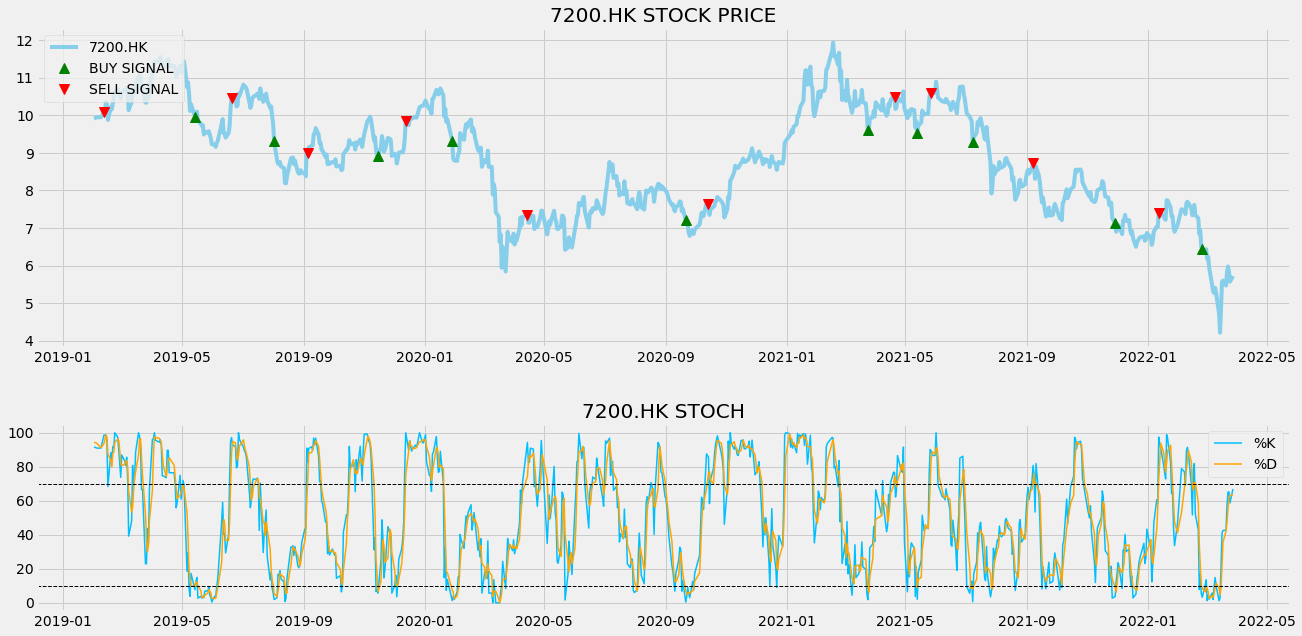

In [1]:
import pandas as pd
import numpy as np
import requests
from termcolor import colored as cl
from math import floor
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime


def get_historical_data(symbol, start_date=None):
    data = yf.download(
        symbol,
        start=start_date,
        end=datetime.now().strftime("%Y-%m-%d"),
        progress=False,
    )
    return data


def stoch(df, n):
    high = df["High"].rolling(n).max()
    low = df["Low"].rolling(n).min()
    K = (df["Close"] - low) * 100 / (high - low)
    D = K.rolling(3).mean()
    return K, D


def plot_stoch(symbol, price, k, d):
    ax1 = plt.subplot2grid((9, 1), (0, 0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((9, 1), (6, 0), rowspan=3, colspan=1)
    ax1.plot(price)
    ax1.set_title(f"{symbol} STOCK PRICE")
    ax2.plot(k, color="deepskyblue", linewidth=1.5, label="%K")
    ax2.plot(d, color="orange", linewidth=1.5, label="%D")
    ax2.axhline(upper_threshold, color="black", linewidth=1, linestyle="--")
    ax2.axhline(lower_threshold, color="black", linewidth=1, linestyle="--")
    ax2.set_title(f"{symbol} STOCH")
    ax2.legend()
    plt.show()


# plot_stoch(stock_tick, data["Close"], data["%k"], data["%d"])


def implement_stoch_strategy(prices, k, d, lower_threshold, upper_threshold):
    buy_price = []
    sell_price = []
    stoch_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < lower_threshold and d[i] < lower_threshold and k[i] < d[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        elif k[i] > upper_threshold and d[i] > upper_threshold and k[i] > d[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_signal.append(0)

    return buy_price, sell_price, stoch_signal


def get_benchmark(start_date, investment_value):
    spy = get_historical_data("SPY", start_date)["Close"]
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns={0: "benchmark_returns"})

    investment_value = investment_value
    number_of_stocks = floor(investment_value / spy[-1])
    benchmark_investment_ret = []

    for i in range(len(benchmark["benchmark_returns"])):
        returns = number_of_stocks * benchmark["benchmark_returns"][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(
        columns={0: "investment_returns"}
    )
    return benchmark_investment_ret_df



plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use("fivethirtyeight")

stock_tick = "7200.HK"
start_date = "2019-01-01"
period = 21
upper_threshold = 70
lower_threshold = 10

data = get_historical_data(stock_tick, start_date)

data["%k"], data["%d"] = stoch(data, period)
data = data.dropna()

buy_price, sell_price, signal = implement_stoch_strategy(
    data["Close"], data["%k"], data["%d"], lower_threshold, upper_threshold
)

ax1 = plt.subplot2grid((9, 1), (0, 0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((9, 1), (6, 0), rowspan=3, colspan=1)
ax1.plot(data["Close"], color="skyblue", label=stock_tick)
ax1.plot(
    data.index,
    buy_price,
    marker="^",
    color="green",
    markersize=10,
    label="BUY SIGNAL",
    linewidth=0,
)
ax1.plot(
    data.index,
    sell_price,
    marker="v",
    color="r",
    markersize=10,
    label="SELL SIGNAL",
    linewidth=0,
)
ax1.legend(loc="upper left")
ax1.set_title(stock_tick + " STOCK PRICE")
ax2.plot(data["%k"], color="deepskyblue", linewidth=1.5, label="%K")
ax2.plot(data["%d"], color="orange", linewidth=1.5, label="%D")
ax2.axhline(upper_threshold, color="black", linewidth=1, linestyle="--")
ax2.axhline(lower_threshold, color="black", linewidth=1, linestyle="--")
ax2.set_title(stock_tick + " STOCH")
ax2.legend()
plt.show()

In [2]:
# pd.concat([buy_price, sell_price, signal], join="inner", axis=1)
profile = pd.DataFrame()
profile['signal'] = signal
profile = profile.set_index(data.index)
profile['Close'] = data["Close"]
profile

,signal,Close
Date,,
2019-02-01,0,9.920
2019-02-04,0,9.950
2019-02-08,0,9.950
2019-02-11,-1,10.080
2019-02-12,0,10.120
...,...,...
2022-03-22,0,5.830
2022-03-23,0,5.975
2022-03-24,0,5.845


In [3]:

transaction = pd.DataFrame()
bet_size = 1
PL = 0 
stock_amount =0 
stock_cost = 0 
for i in range (0,len(profile['signal'])): 
    signal_col_index = profile.columns.get_loc("signal")
    price_col_index = profile.columns.get_loc("Close")
    signal = profile.iloc[i,signal_col_index]
    if signal ==1: 
        index = profile.index[i]
        price = profile.iloc[i, price_col_index]
        stock_cost += profile.iloc[i, price_col_index]
        action = "BUY"
        stock_amount+=1
        new_row = pd.DataFrame({"index":[index],"price":[price], "action":[action], "stock_amount":stock_amount, "stock_cost":stock_cost, "PL":PL})
        transaction = pd.concat((transaction,new_row),axis=0)
        
        
    elif signal ==-1 and stock_amount != 0: 
        index = profile.index[i]
        price = profile.iloc[i, price_col_index]
        action = "SELL"
        PL +=price * transaction.iloc[-1]['stock_amount'] - transaction.iloc[-1]['stock_cost']
        stock_cost=0
        stock_amount=0
        new_row = pd.DataFrame({"index":[index],"price":[price], "action":[action], "stock_amount":stock_amount, "stock_cost":0, "PL":PL})
        transaction = pd.concat((transaction,new_row), axis=0)
        
return_rate = round(PL/sum(transaction['stock_cost']),2)*100
print(f" Return Rate: {return_rate} %")
transaction

 Return Rate: 1.0 %


,index,price,action,stock_amount,stock_cost,PL
0,2019-05-14,9.970,BUY,1,9.970,0.000000
0,2019-06-20,10.460,SELL,0,0.000,0.490000
0,2019-08-02,9.310,BUY,1,9.310,0.490000
0,2019-09-05,9.010,SELL,0,0.000,0.190000
0,2019-11-15,8.920,BUY,1,8.920,0.190000
...,...,...,...,...,...,...
0,2021-07-08,9.300,BUY,1,9.300,1.505001
0,2021-09-07,8.730,SELL,0,0.000,0.935000
0,2021-11-29,7.120,BUY,1,7.120,0.935000
0,2022-01-12,7.395,SELL,0,0.000,1.210001


In [11]:
import talib as ta
import plotly.express as px
import numpy as np

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
# calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name="ROC_" + str(n))
    return ROC
data["K"], data["D"] = stoch(data, 20)
data['ROC'] = ROC(data['Close'],63)
data['RSI'] = ta.RSI(data['Close'],21)
data['date'] = data.index
data['OBV'] = ta.OBV(data['Close'], data['Volume'])
data['OBV_slope'] = NormalizeData(ta.LINEARREG_SLOPE(data['OBV'],5))
data["MA10"] = ta.SMA(data['Close'],10)
data["MA10_slope"] = ta.LINEARREG_SLOPE(data['MA10'])
data["MA20"] = ta.SMA(data['Close'],20)
data["MA20_slope"] = ta.LINEARREG_SLOPE(data['MA20'],5)
data["MA120"] = ta.SMA(data['Close'],120)
data["MA120_slope"] = ta.LINEARREG_SLOPE(data['MA120'],10)



C:\Users\PC\AppData\Local\Temp/ipykernel_9756/550872438.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp/ipykernel_9756/550872438.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp/ipykernel_9756/550872438.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def price_compare(df,col1):
    trace1 = go.Candlestick(x=data.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'], yaxis='y1',
                    name="Price")

    trace2 = go.Line(x=df['date'], y=df[col1],yaxis='y2',line = dict(color='#eb9234', width=3),name=col1)
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.show()
price_compare(data,'MA120_slope')

In [7]:

def linechart_compare(df, col1, col2):
    trace1 = go.Line(x=df['date'], y=df[col1],yaxis='y1',name=col1, line = dict(color='royalblue', width=3))
    trace2 = go.Line(x=df['date'], y=df[col2],yaxis='y2',name=col2,line = dict(color='#eb9234', width=3))
    fig = make_subplots(specs=[[{"secondary_y": True}]],subplot_titles=[f"Comparison between ({col1}) and ({col2})"])
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.show()

linechart_compare(data,'MA120_slope','MA20_slope')

In [203]:
for index, row in data[data['Open'] > 700].iterrows():
    print(row['Close'])

766.5
718.5
701.5
724.5
736.0
735.5
733.0
736.5
740.5
761.0
757.0
745.0
757.5
747.5
741.0
713.5
687.0
698.0
690.0


In [15]:
import math
from datetime import datetime
def yearly_return(start_date, end_date, all_profit_percent): 
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    years = int((now - start).days/365)
    yearly_return = (pow(all_profit_percent, 1/years)-1)*100
    return yearly_return

yearly_return("2000-01-01","2022-01-01",1000)

36.88745095370809